In [2]:
import data_process
reload(data_process)
import research
reload(research)
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeRegressor
from sklearn

In [3]:
target = 'ru0'
train_start, train_end, test_start, test_end = '20180326', ' 20180329', '20180330', '20180330'
period = '1s'
if period == '0s':
    lag = '500ms'
else:
    lag = period
resample = False
resample_period = '2s'

In [4]:
rese = research.Research(target=target)
train = research.Train(target = target)

In [44]:
tickerlst = rese.get_symbols(num=30)
print tickerlst

['rb0', 'hc0', 'ni0', 'zn0', 'cu0', 'j10', 'i10', 'jm0', 'MA0', 'pb0', 'pp0', 'TA0', 'al0', 'ZC0', 'SM0', 'FG0', 'l10', 'bu0', 'OI0', 'sn0', 'SF0', 'CF0', 'RI0', 'v10', 'p10', 'RM0', 'y10', 'CY0', 'AP0', 'fb0']


In [6]:
train_daylst = rese.generate_daylst(train_start, train_end)
test_daylst = rese.generate_daylst(test_start, test_end)
train_data = rese.load_data(tickerlst, daylst=train_daylst, lag=lag, period = period)
test_data = rese.load_data(tickerlst, daylst=test_daylst, lag=lag, period = period)

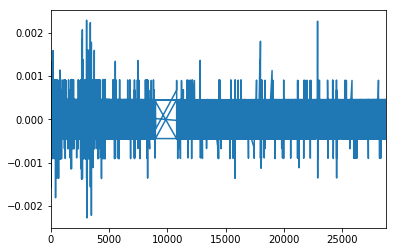

In [7]:
none_zero_flag = [True if val != 0 else False for val in train_data[target].values]
none_zero = train_data[none_zero_flag]
none_zero[target].plot()
plt.show()

std of train data is 0.000144


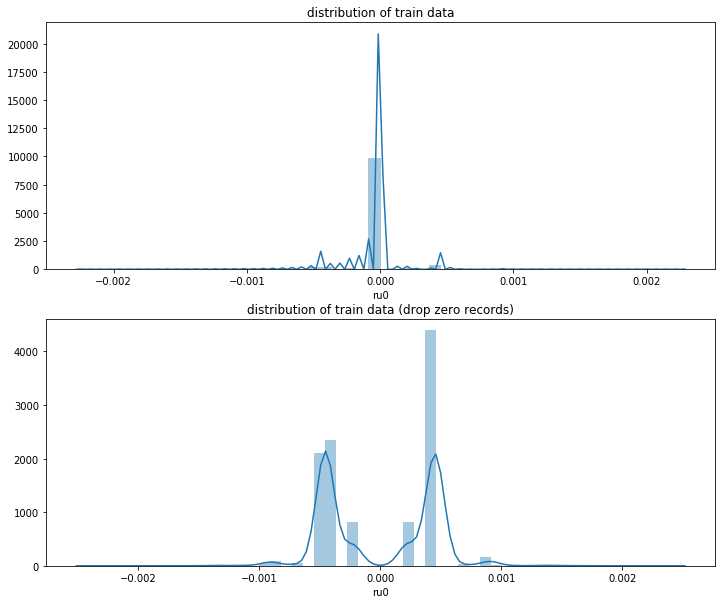

std of none-zero df is 0.000463


In [8]:
plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
plt.title('distribution of train data')
sns.distplot(train_data[target])
print 'std of train data is %f' %np.std(train_data[target].values)

plt.subplot(2,1,2)
sns.distplot(none_zero[target])
plt.title('distribution of train data (drop zero records)')
plt.show()
none_zero_std = np.std(none_zero[target])
print 'std of none-zero df is %f' %none_zero_std

           std of train data is 0.000144, mean of train data is 0.000000


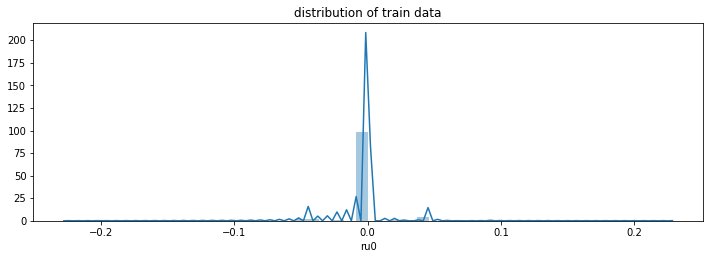

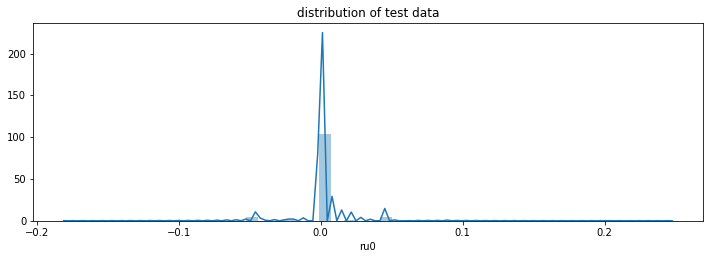

           std of test data is 0.000145, mean of train data is 0.000001


In [9]:
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.title('distribution of train data')
sns.distplot(train_data[target]*100)
print '           std of train data is %f, mean of train data is %f' %(np.std(train_data[target].values), np.mean(train_data[target].values))

plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.title('distribution of test data')
sns.distplot(test_data[target]*100)
plt.show()
print '           std of test data is %f, mean of train data is %f' %(np.std(test_data[target].values),np.mean(test_data[target].values))

In [10]:
train_price = rese.load_price(train_daylst,lag)
test_price = rese.load_price(test_daylst, lag)

In [11]:
train_x, train_y = train.split_x_y(train_data)

In [30]:
def easy_ensemble(data, clf, target=target,n_model='default', zero_no_zero_times = 2, cut_outlier=True):
    if n_model == 'default':
        count = 0  # 0记录的数量
        for val in data[target].values:
            if val == 0:
                count += 1
        l = data.shape[0]
        n_model = count / (l - count) / zero_no_zero_times  # 使得划分的模型数和0值、非0值比值是指定的比值，这样就能保证每个clf的数据里非0和0值差不多
    target_col = data[target].values
    zero_flag = [True if val == 0 else False for val in target_col]
    not_zero_flag = [True if val != 0 else False for val in target_col]
    zero_records = data[zero_flag]
    not_zero_records = data[not_zero_flag]
    if cut_outlier:  # 去掉非零值中的outliers
        mean = np.mean(not_zero_records.values)
        std = np.std(not_zero_records.values)
        flag=[]
        for val in not_zero_records[target].values:
            flag1, flag2 = False, False
            to_test_1, to_test_2 = mean+3*std,mean-3*std
            if val < to_test_1:
                flag1 = True
            if val > to_test_2:
                flag2 = True
            if flag1 and flag2:
                flag.append(True)
            else:
                flag.append(False)
        not_zero_records = not_zero_records[flag]
    zero_dic = df_split(zero_records, n=n_model)
    clf_dic, train_score = {}, {}
    for key in zero_dic.keys():
        this_df = pd.concat([not_zero_records, zero_dic[key]])
        this_df = shuffle(this_df)
        this_x, this_y = train.split_x_y(this_df)
        clf.fit(this_x, this_y)
        train_score[key] = clf.score(this_x, this_y)
        clf_dic[key] = clf
    return clf_dic, train_score
        
def df_split(data, n):
    '''split dataframe into n parts'''
    data = shuffle(data)
    l = data.shape[0]
    len_per_part = l/n
    dic = {}
    num=1
    start=0
    while num< n:
        end = start+len_per_part
        temp = data.iloc[start:end,:]
        dic[str(num)] = temp
        start=end
        num+=1
    dic[str(n)] = data.iloc[start:,:]
    return dic

def cut_outlier(data, target_col=target, thres=3):   # 去掉数值大于thres倍方差的
    df = data.copy()
    scaled = StandardScaler().fit_transform(df[target_col][:,np.newaxis])
    flag = [True if abs(val) <= thres else False for val in scaled]
    return data[flag]

def easy_ensemble_predict(x, clf_dic, score_dic):
    score_sum = sum(score_dic.values())
    weight = {}
    res = [0 for i in range(x.shape[0])]
    for key in score_dic.keys():
        weight[key] = score_dic[key]/ score_sum
        this_clf = clf_dic[key]
        this_pred = this_clf.predict(x)
        res += weight[key] * this_pred
    return res

def asset_plot(asset_record):
    max_list, min_list = [], []
    values = asset_record.values()
    for i in range(len(asset_record)):
        max_list.append(values[i][0])
        min_list.append(values[i][1])
    plt.plot(max_list, label='max')
    plt.plot(min_list, label='min')
    plt.legend()
    plt.show()

def get_best_thres(dic, max_weight = 1, min_weight = 1): # 从asset记录中获取最好的一条记录
    profit = map(lambda set_x : [int(set_x[0])-5000000,int(set_x[-1])-5000000], dic.values())
    max_profit = -1000000
    best_thres = 0
    for i in range(len(profit)):
        this_profit = profit[i][0] + profit[i][1]
        if this_profit > max_profit:
            max_profit = this_profit
            best_thres = i
            print profit[i][0], profit[i][1]
    return dic.keys()[best_thres]

def get_best_thres_by_tr_test(train_dic, test_dic, train_weig, test_weig, max_weight = 1, min_weight = 1): # 从asset记录中获取最好的一条记录
    train_profit = map(lambda set_x : [int(set_x[0])-5000000,int(set_x[-1])-5000000], train_dic.values())
    test_profit = map(lambda set_x : [int(set_x[0])-5000000,int(set_x[-1])-5000000], test_dic.values())
    max_profit = -1000000
    best_thres = 0
    for i in range(len(train_profit)):
        this_profit = (train_profit[i][0] + train_profit[i][1])*train_weig+(test_profit[i][0] + test_profit[i][1])*test_weig
        if this_profit > max_profit:
            max_profit = this_profit
            best_thres = i
            print test_profit[i][0], test_profit[i][1]
    return train_dic.keys()[best_thres]

In [66]:
clf = DecisionTreeRegressor(criterion='mse',max_depth=5,)
clf_dic , score_dic = easy_ensemble(train_data, clf, zero_no_zero_times=1)

In [72]:
train_predict = easy_ensemble_predict(train_x, clf_dic,score_dic={'1':1,'2':1,'3':1,'4':1})

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

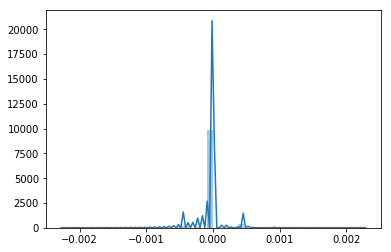

In [40]:
sns.distplot(train_y)
plt.show()

In [50]:
path= clf.tree_.decision_path(np.float32(train_x))

In [60]:
from sklearn.externals.six import StringIO
from sklearn import  tree
with open('future.dot', 'w') as f:
    f = tree.export_graphviz(clf, out_file=f)

ImportError: No module named pydot